In [97]:
# Import Librerie Necessarie
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import community as community_louvain # Rimosso: usiamo implementazione nativa NetworkX per evitare conflitti
from networkx.algorithms import community
import itertools
import os

# Configurazione stile grafici
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Creazione cartella per i grafici se non esiste
output_folder = "./grafici"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Cartella '{output_folder}' creata.")
else:
    print(f"Cartella '{output_folder}' già esistente.")

Cartella './grafici' già esistente.


In [98]:
# Lettura del File GML
file_path = '../data/cyber_incidents_graph.gml'

if os.path.exists(file_path):
    print(f"Caricamento del grafo da: {file_path}")
    G = nx.read_gml(file_path)
    print("Grafo caricato con successo.")
    print(f"Numero di nodi: {G.number_of_nodes()}")
    print(f"Numero di archi: {G.number_of_edges()}")
    print(f"Tipo di grafo: {'Diretto' if G.is_directed() else 'Non Diretto'}")
else:
    print(f"ERRORE: Il file {file_path} non è stato trovato. Verificare il percorso.")

Caricamento del grafo da: ../data/cyber_incidents_graph.gml
Grafo caricato con successo.
Numero di nodi: 54
Numero di archi: 88
Tipo di grafo: Diretto


--- Analisi delle Triadi ---
Risultati Censimento Triadi:
  Transitive (030T): 16
  Fan-out (021D): 399
  Fan-in (021U): 23


C:\Users\luca1\AppData\Local\Temp\ipykernel_18068\1578307836.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(triad_analysis.keys()), y=list(triad_analysis.values()), palette='viridis')


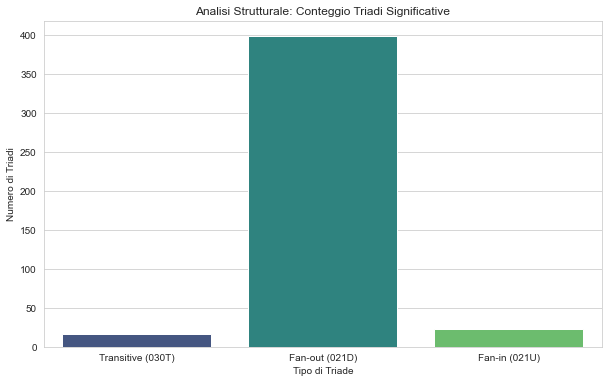


Generazione visualizzazione Fan-out (021D) - Dettaglio 5 Attaccanti Distinti...
Selezionate 5 triadi Fan-out da 5 attaccanti distinti.


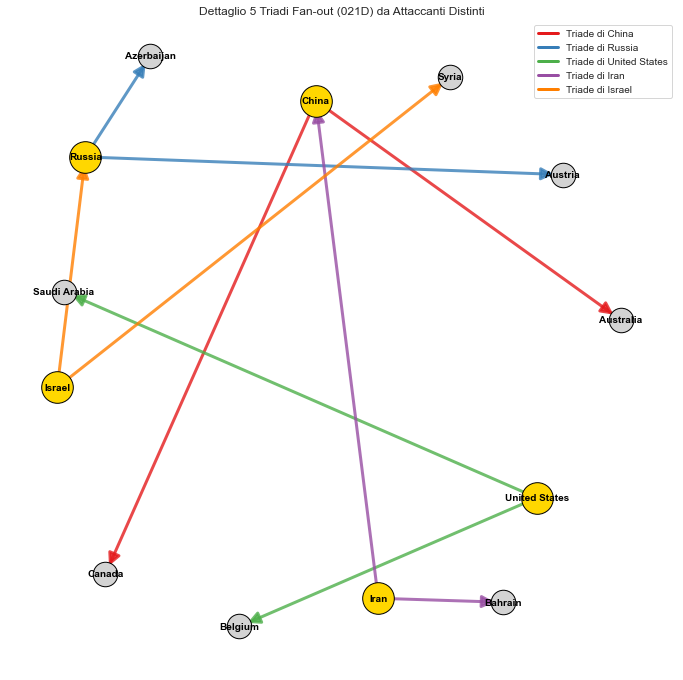


Generazione visualizzazione Fan-in (021U) - Dettaglio 3 Bersagli Distinti...
Selezionate 3 triadi Fan-in su 3 bersagli distinti.


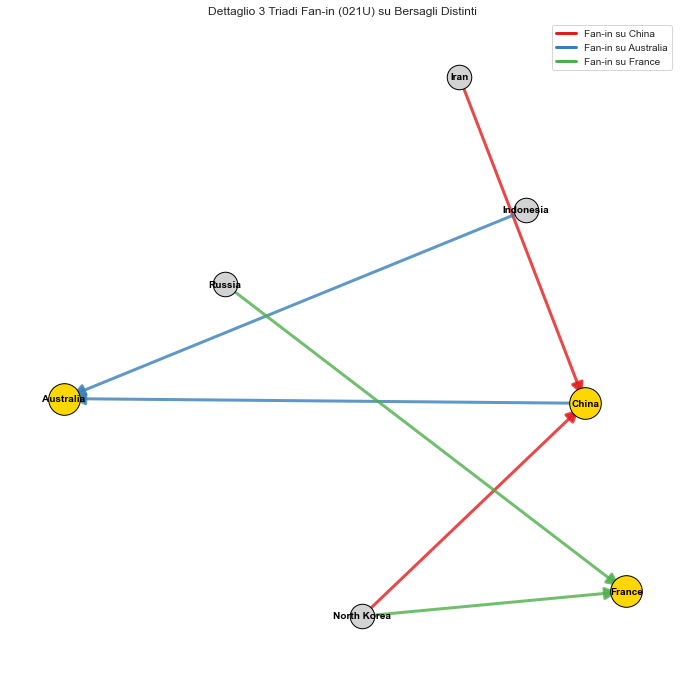


Generazione visualizzazione Transitive (030T) - Dettaglio 3 Sorgenti Distinte...
Selezionate 3 triadi Transitive da 3 sorgenti distinte.


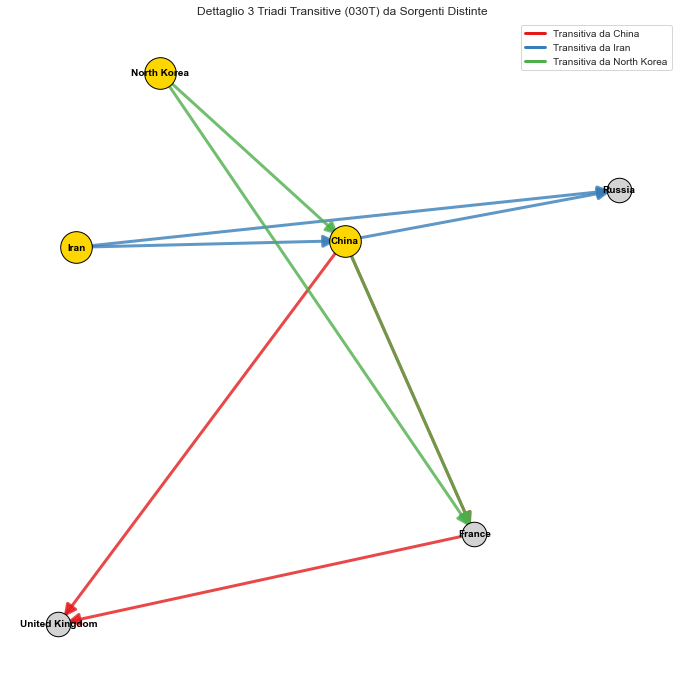

In [ ]:
# Analisi delle Triadi: Transitive, Cicliche, Fan-in, Fan-out
print("--- Analisi delle Triadi ---")

# Calcolo del censimento delle triadi
triadic_census = nx.triadic_census(G)

# Estrazione delle configurazioni di interesse
# 030T: Transitive (A->B, B->C, A->C)
# 021D: Fan-out (A->B, A->C) - Un nodo sorgente verso due destinazioni
# 021U: Fan-in (A->B, C->B) - Due nodi sorgente verso una destinazione

triad_analysis = {
    'Transitive (030T)': triadic_census.get('030T', 0),
    'Fan-out (021D)': triadic_census.get('021D', 0),
    'Fan-in (021U)': triadic_census.get('021U', 0)
}

# Output testuale
print("Risultati Censimento Triadi:")
for t_type, count in triad_analysis.items():
    print(f"  {t_type}: {count}")

# Visualizzazione Grafica
plt.figure(figsize=(10, 6))
sns.barplot(x=list(triad_analysis.keys()), y=list(triad_analysis.values()), palette='viridis')
plt.title("Analisi Strutturale: Conteggio Triadi Significative")
plt.ylabel("Numero di Triadi")
plt.xlabel("Tipo di Triade")
plt.savefig(f"{output_folder}/03.2_triadi_census.png")
plt.show()

from matplotlib.lines import Line2D

# --- Visualizzazione Fan-out (021D) Dettagliata ---
print("\nGenerazione visualizzazione Fan-out (021D) - Dettaglio 5 Attaccanti Distinti...")

selected_triads = []
seen_sources = set()

# Identificazione triadi 021D (A->B, A->C, no altri archi tra A,B,C)
# Cerchiamo 5 sorgenti diverse
for u in G.nodes():
    if u in seen_sources:
        continue
        
    successors = list(G.successors(u))
    if len(successors) < 2:
        continue
    
    # Cerca una triade valida per questo nodo sorgente
    for v, w in itertools.combinations(successors, 2):
        # Verifica stretta 021D: solo archi u->v e u->w nel sottografo {u,v,w}
        if not (G.has_edge(v, u) or G.has_edge(w, u) or G.has_edge(v, w) or G.has_edge(w, v)):
            selected_triads.append((u, v, w))
            seen_sources.add(u)
            break # Trovata una triade per questo attaccante, passiamo al prossimo
            
    if len(selected_triads) >= 5:
        break

print(f"Selezionate {len(selected_triads)} triadi Fan-out da {len(seen_sources)} attaccanti distinti.")

plt.figure(figsize=(12, 12))

# Costruiamo un grafo temporaneo solo per la visualizzazione
G_viz = nx.DiGraph()
# Palette colori distinta per le 5 triadi
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00'] # Set 1 palette

# Aggiungiamo nodi e archi al grafo di visualizzazione
for u, v, w in selected_triads:
    G_viz.add_edge(u, v)
    G_viz.add_edge(u, w)

# Calcolo layout
pos = nx.spring_layout(G_viz, seed=42, k=2.0) # k alto per separare bene le componenti

# Disegna nodi
# Attaccanti (Sorgenti) in evidenza
nx.draw_networkx_nodes(G_viz, pos, nodelist=list(seen_sources), node_size=1000, node_color='gold', edgecolors='black', label='Attaccanti')
# Bersagli
targets = [n for n in G_viz.nodes() if n not in seen_sources]
nx.draw_networkx_nodes(G_viz, pos, nodelist=targets, node_size=600, node_color='lightgray', edgecolors='black', label='Bersagli')

nx.draw_networkx_labels(G_viz, pos, font_size=10, font_weight='bold')

# Disegna archi colorati per ogni triade
legend_elements = []

for i, (u, v, w) in enumerate(selected_triads):
    color = colors[i % len(colors)]
    # Disegna gli archi della triade corrente
    nx.draw_networkx_edges(G_viz, pos, edgelist=[(u, v), (u, w)], 
                           edge_color=color, width=3.0, arrowsize=25, alpha=0.8)
    
    # Elemento per la legenda
    legend_elements.append(Line2D([0], [0], color=color, lw=3, label=f'Triade di {u}'))

plt.title("Dettaglio 5 Triadi Fan-out (021D) da Attaccanti Distinti")
plt.legend(handles=legend_elements, loc='upper right')
plt.axis('off')
plt.savefig(f"{output_folder}/03.2_fan_out_visualization_detail.png")
plt.show()

# --- Visualizzazione Fan-in (021U) Dettagliata ---
print("\nGenerazione visualizzazione Fan-in (021U) - Dettaglio 3 Bersagli Distinti...")

selected_triads_in = []
seen_targets = set()

# Identificazione triadi 021U (A->B, C->B)
# Cerchiamo 3 bersagli diversi
for v in G.nodes():
    if v in seen_targets:
        continue
        
    predecessors = list(G.predecessors(v))
    if len(predecessors) < 2:
        continue
    
    for u, w in itertools.combinations(predecessors, 2):
        # Verifica stretta 021U: solo archi u->v e w->v
        sub_nodes = {u, v, w}
        sub = G.subgraph(sub_nodes)
        if sub.number_of_edges() == 2 and sub.has_edge(u, v) and sub.has_edge(w, v):
            selected_triads_in.append((u, w, v)) # u, w sono sorgenti, v è bersaglio
            seen_targets.add(v)
            break
            
    if len(selected_triads_in) >= 3:
        break

print(f"Selezionate {len(selected_triads_in)} triadi Fan-in su {len(seen_targets)} bersagli distinti.")

plt.figure(figsize=(12, 12))
G_viz_in = nx.DiGraph()
colors_in = ['#e41a1c', '#377eb8', '#4daf4a'] # 3 colori

for u, w, v in selected_triads_in:
    G_viz_in.add_edge(u, v)
    G_viz_in.add_edge(w, v)

pos_in = nx.spring_layout(G_viz_in, seed=42, k=2.0)

# Disegna nodi
nx.draw_networkx_nodes(G_viz_in, pos_in, nodelist=list(seen_targets), node_size=1000, node_color='gold', edgecolors='black', label='Bersagli (Focus)')
sources_in = [n for n in G_viz_in.nodes() if n not in seen_targets]
nx.draw_networkx_nodes(G_viz_in, pos_in, nodelist=sources_in, node_size=600, node_color='lightgray', edgecolors='black', label='Attaccanti')

nx.draw_networkx_labels(G_viz_in, pos_in, font_size=10, font_weight='bold')

legend_elements_in = []
for i, (u, w, v) in enumerate(selected_triads_in):
    color = colors_in[i % len(colors_in)]
    nx.draw_networkx_edges(G_viz_in, pos_in, edgelist=[(u, v), (w, v)], 
                           edge_color=color, width=3.0, arrowsize=25, alpha=0.8)
    legend_elements_in.append(Line2D([0], [0], color=color, lw=3, label=f'Fan-in su {v}'))

plt.title("Dettaglio 3 Triadi Fan-in (021U) su Bersagli Distinti")
plt.legend(handles=legend_elements_in, loc='upper right')
plt.axis('off')
plt.savefig(f"{output_folder}/03.2_fan_in_visualization_detail.png")
plt.show()


# --- Visualizzazione Transitive (030T) Dettagliata ---
print("\nGenerazione visualizzazione Transitive (030T) - Dettaglio 3 Sorgenti Distinte...")

selected_triads_trans = []
seen_origins = set()

# Identificazione triadi 030T (A->B, B->C, A->C)
for u in G.nodes():
    if u in seen_origins:
        continue
        
    successors = list(G.successors(u))
    found_triad = False
    
    for v in successors:
        if found_triad: break
        v_successors = list(G.successors(v))
        
        for w in v_successors:
            if w in successors: # Esiste A->C
                # Verifica stretta 030T: esattamente 3 archi A->B, B->C, A->C
                sub_nodes = {u, v, w}
                sub = G.subgraph(sub_nodes)
                if sub.number_of_edges() == 3:
                    selected_triads_trans.append((u, v, w))
                    seen_origins.add(u)
                    found_triad = True
                    break
                    
    if len(selected_triads_trans) >= 3:
        break

print(f"Selezionate {len(selected_triads_trans)} triadi Transitive da {len(seen_origins)} sorgenti distinte.")

plt.figure(figsize=(12, 12))
G_viz_trans = nx.DiGraph()
colors_trans = ['#e41a1c', '#377eb8', '#4daf4a']

for u, v, w in selected_triads_trans:
    G_viz_trans.add_edge(u, v)
    G_viz_trans.add_edge(v, w)
    G_viz_trans.add_edge(u, w)

pos_trans = nx.spring_layout(G_viz_trans, seed=42, k=2.0)

# Disegna nodi
nx.draw_networkx_nodes(G_viz_trans, pos_trans, nodelist=list(seen_origins), node_size=1000, node_color='gold', edgecolors='black', label='Sorgenti (Focus)')
others_trans = [n for n in G_viz_trans.nodes() if n not in seen_origins]
nx.draw_networkx_nodes(G_viz_trans, pos_trans, nodelist=others_trans, node_size=600, node_color='lightgray', edgecolors='black', label='Altri Nodi')

nx.draw_networkx_labels(G_viz_trans, pos_trans, font_size=10, font_weight='bold')

legend_elements_trans = []
for i, (u, v, w) in enumerate(selected_triads_trans):
    color = colors_trans[i % len(colors_trans)]
    nx.draw_networkx_edges(G_viz_trans, pos_trans, edgelist=[(u, v), (v, w), (u, w)], 
                           edge_color=color, width=3.0, arrowsize=25, alpha=0.8)
    legend_elements_trans.append(Line2D([0], [0], color=color, lw=3, label=f'Transitiva da {u}'))

plt.title("Dettaglio 3 Triadi Transitive (030T) da Sorgenti Distinte")
plt.legend(handles=legend_elements_trans, loc='upper right')
plt.axis('off')
plt.savefig(f"{output_folder}/03.2_transitive_visualization_detail.png")
plt.show()

--- Analisi di Clustering ---
Coefficiente di Clustering Medio del Network: 0.1104

Top 10 Paesi per Coefficiente di Clustering:
         Paese  Clustering_Coeff  Degree
       Vietnam          1.000000       3
  Saudi Arabia          0.833333       3
       Germany          0.500000       2
        Canada          0.500000       2
    Bangladesh          0.500000       2
        France          0.500000       4
         Italy          0.500000       2
   South Korea          0.277778       5
United Kingdom          0.250000      10
          Iran          0.207547      11

Correlazione tra Degree e Clustering Coefficient: 0.1073


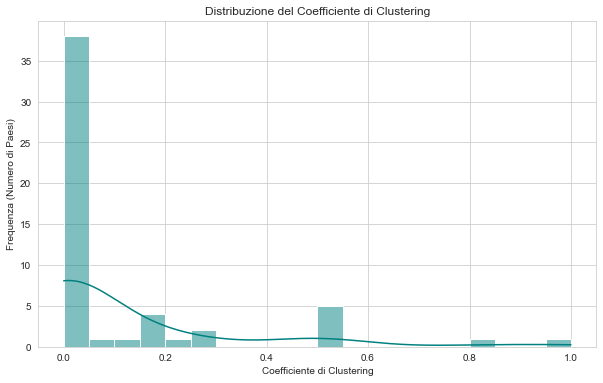

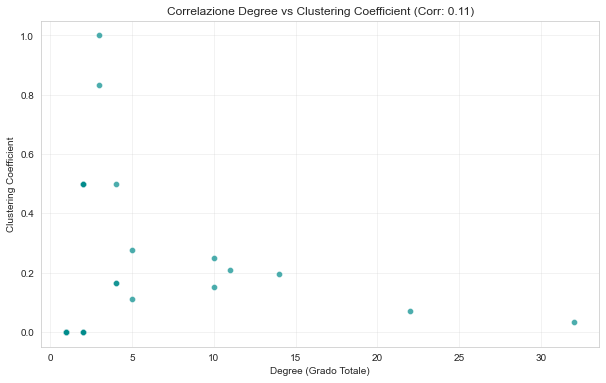

In [ ]:
# Analisi di Clustering
print("--- Analisi di Clustering ---")

# Calcolo coefficienti di clustering (per grafi diretti)
clustering_coeffs = nx.clustering(G)
avg_clustering = nx.average_clustering(G)

print(f"Coefficiente di Clustering Medio del Network: {avg_clustering:.4f}")

# Top 10 Paesi per Clustering Coefficient
df_clustering = pd.DataFrame(list(clustering_coeffs.items()), columns=['Paese', 'Clustering_Coeff'])

# Aggiunta del Degree per calcolo correlazione
degrees = dict(G.degree())
df_clustering['Degree'] = df_clustering['Paese'].map(degrees)

df_clustering = df_clustering.sort_values(by='Clustering_Coeff', ascending=False)

print("\nTop 10 Paesi per Coefficiente di Clustering:")
print(df_clustering.head(10).to_string(index=False))

# Calcolo Correlazione
correlation = df_clustering['Degree'].corr(df_clustering['Clustering_Coeff'])
print(f"\nCorrelazione tra Degree e Clustering Coefficient: {correlation:.4f}")

# Visualizzazione Distribuzione
plt.figure(figsize=(10, 6))
sns.histplot(df_clustering['Clustering_Coeff'], bins=20, kde=True, color='teal')
plt.title("Distribuzione del Coefficiente di Clustering")
plt.xlabel("Coefficiente di Clustering")
plt.ylabel("Frequenza (Numero di Paesi)")
plt.savefig(f"{output_folder}/03.2_clustering_distribution.png")
plt.show()

# Visualizzazione Correlazione (Scatter Plot) con Nomi Paesi
plt.figure(figsize=(14, 10)) # Aumentata dimensione per leggibilità etichette
sns.scatterplot(data=df_clustering, x='Degree', y='Clustering_Coeff', color='darkcyan', alpha=0.7, s=100)

# Aggiunta etichette per ogni paese
for i in range(df_clustering.shape[0]):
    plt.text(
        x=df_clustering.Degree.iloc[i]+0.5, # Leggero offset a destra
        y=df_clustering.Clustering_Coeff.iloc[i], 
        s=df_clustering.Paese.iloc[i], 
        horizontalalignment='left', 
        size='small', 
        color='black', 
        weight='semibold',
        alpha=0.8
    )

plt.title(f"Correlazione Degree vs Clustering Coefficient (Corr: {correlation:.2f})")
plt.xlabel("Degree (Grado Totale)")
plt.ylabel("Clustering Coefficient")
plt.grid(True, alpha=0.3)
plt.savefig(f"{output_folder}/03.2_clustering_degree_correlation.png")
plt.show()

--- Analisi delle Clique ---
Numero totale di clique massimali individuate: 54
Dimensione della clique massima (Maximum Clique): 5
Numero di clique di dimensione massima: 1
Esempio di clique massima (primi 10 nodi): ['Russia', 'China', 'Iran', 'United States', 'United Kingdom']...


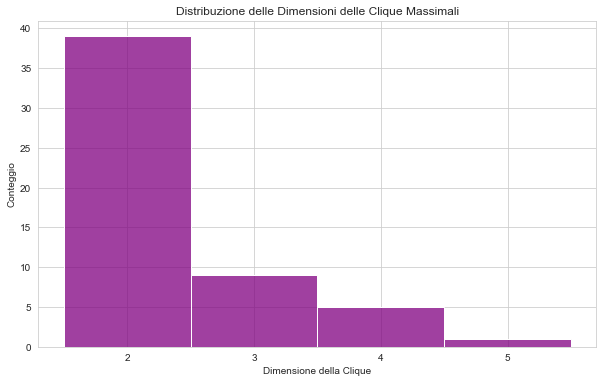

In [101]:
# Analisi delle Clique e Clique Massima
print("--- Analisi delle Clique ---")

# Le clique sono definite su grafi non orientati. Convertiamo per questa analisi.
G_undirected = G.to_undirected()

# Trova tutte le clique massimali
cliques = list(nx.find_cliques(G_undirected))
num_cliques = len(cliques)

# Trova la dimensione della clique massima
max_clique_size = len(max(cliques, key=len))
max_cliques = [c for c in cliques if len(c) == max_clique_size]

print(f"Numero totale di clique massimali individuate: {num_cliques}")
print(f"Dimensione della clique massima (Maximum Clique): {max_clique_size}")
print(f"Numero di clique di dimensione massima: {len(max_cliques)}")
print(f"Esempio di clique massima (primi 10 nodi): {max_cliques[0][:10]}...")

# Visualizzazione Distribuzione Dimensioni
clique_sizes = [len(c) for c in cliques]
plt.figure(figsize=(10, 6))
sns.histplot(clique_sizes, bins=range(min(clique_sizes), max(clique_sizes) + 2), discrete=True, color='purple')
plt.title("Distribuzione delle Dimensioni delle Clique Massimali")
plt.xlabel("Dimensione della Clique")
plt.ylabel("Conteggio")
plt.xticks(range(min(clique_sizes), max(clique_sizes) + 1))
plt.savefig(f"{output_folder}/03.2_clique_size_distribution.png")
plt.show()

--- Analisi K-Core e Struttura a Cipolla ---
Massimo In-K-Core (Shell Index): 2
Massimo Out-K-Core (Shell Index): 2


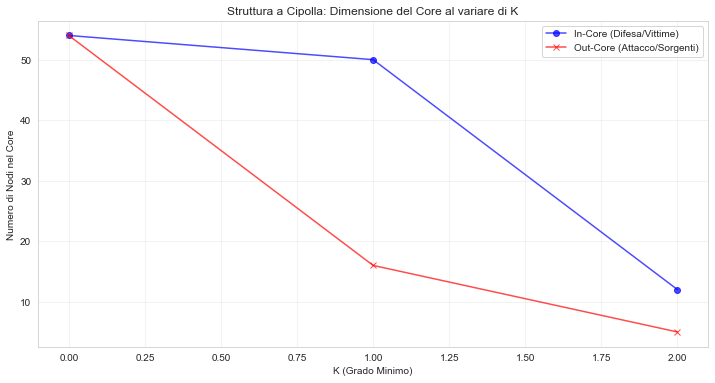

In [102]:
# Analisi In-K-Core, Out-K-Core e Struttura a Cipolla
print("--- Analisi K-Core e Struttura a Cipolla ---")

def get_directed_k_core_sizes(graph, core_type='in'):
    """Calcola la dimensione del k-core per ogni k fino allo svuotamento del grafo."""
    sizes = []
    k = 0
    H = graph.copy()
    while True:
        # Rimuovi nodi con grado < k
        while True:
            if core_type == 'in':
                nodes_to_remove = [n for n, d in H.in_degree() if d < k]
            else:
                nodes_to_remove = [n for n, d in H.out_degree() if d < k]
            
            if not nodes_to_remove:
                break
            H.remove_nodes_from(nodes_to_remove)
        
        if H.number_of_nodes() == 0:
            break
            
        sizes.append((k, H.number_of_nodes()))
        k += 1
    return sizes

in_core_sizes = get_directed_k_core_sizes(G, 'in')
out_core_sizes = get_directed_k_core_sizes(G, 'out')

max_k_in = in_core_sizes[-1][0] if in_core_sizes else 0
max_k_out = out_core_sizes[-1][0] if out_core_sizes else 0

print(f"Massimo In-K-Core (Shell Index): {max_k_in}")
print(f"Massimo Out-K-Core (Shell Index): {max_k_out}")

# Visualizzazione Struttura a Cipolla
plt.figure(figsize=(12, 6))
if in_core_sizes:
    x_in, y_in = zip(*in_core_sizes)
    plt.plot(x_in, y_in, marker='o', label='In-Core (Difesa/Vittime)', color='blue', alpha=0.7)

if out_core_sizes:
    x_out, y_out = zip(*out_core_sizes)
    plt.plot(x_out, y_out, marker='x', label='Out-Core (Attacco/Sorgenti)', color='red', alpha=0.7)

plt.title("Struttura a Cipolla: Dimensione del Core al variare di K")
plt.xlabel("K (Grado Minimo)")
plt.ylabel("Numero di Nodi nel Core")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f"{output_folder}/03.2_k_core_onion_structure.png")
plt.show()

--- Analisi Ego Network ---
Analisi dettagliata per i Top 3 nodi: ['Russia', 'China', 'United States']

Nodo: Russia
  Ego-Net Uscente (Bersagli diretti): 26 vicini
  Ego-Net Entrante (Attaccanti diretti): 6 vicini


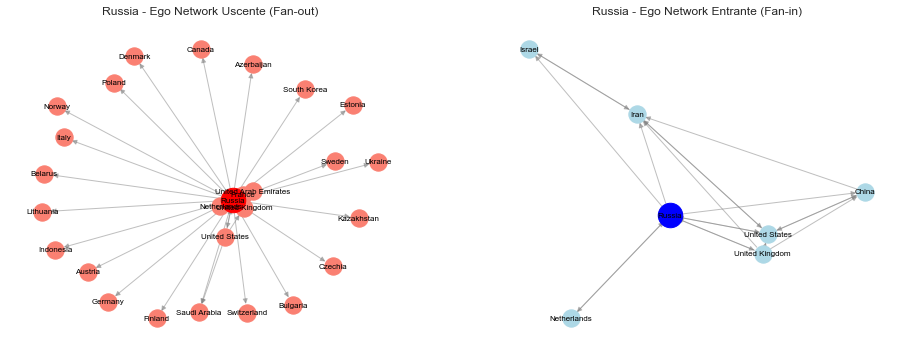


Nodo: China
  Ego-Net Uscente (Bersagli diretti): 18 vicini
  Ego-Net Entrante (Attaccanti diretti): 4 vicini


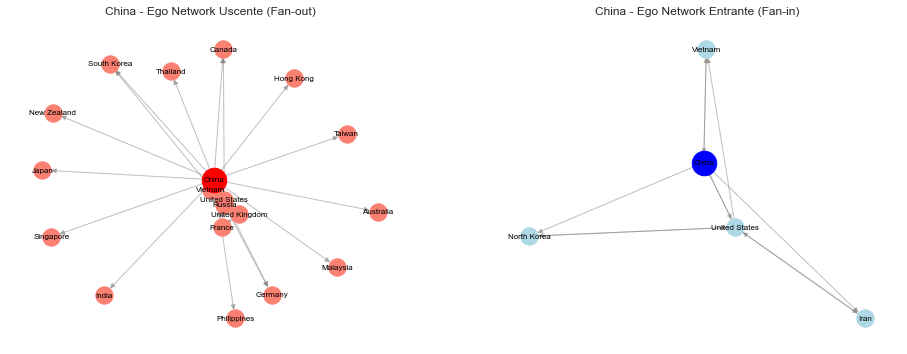


Nodo: United States
  Ego-Net Uscente (Bersagli diretti): 7 vicini
  Ego-Net Entrante (Attaccanti diretti): 7 vicini


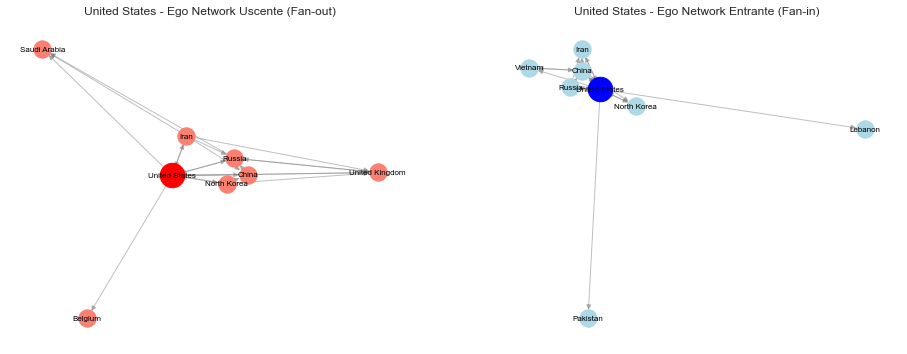

In [103]:
# Analisi Ego Network Entranti e Uscenti
print("--- Analisi Ego Network ---")

# Selezioniamo i 3 nodi più centrali (per grado totale) come esempio
degree_dict = dict(G.degree())
top_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:3]

print(f"Analisi dettagliata per i Top 3 nodi: {top_nodes}")

for node in top_nodes:
    # Ego network uscente (raggio 1)
    ego_out = nx.ego_graph(G, node, radius=1)
    # Ego network entrante (raggio 1 su grafo inverso)
    ego_in = nx.ego_graph(G.reverse(), node, radius=1)
    
    print(f"\nNodo: {node}")
    print(f"  Ego-Net Uscente (Bersagli diretti): {ego_out.number_of_nodes()-1} vicini")
    print(f"  Ego-Net Entrante (Attaccanti diretti): {ego_in.number_of_nodes()-1} vicini")
    
    # Visualizzazione
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot Out
    pos_out = nx.spring_layout(ego_out, seed=42)
    nx.draw_networkx_nodes(ego_out, pos_out, ax=axes[0], node_size=300, node_color='salmon')
    nx.draw_networkx_nodes(ego_out, pos_out, nodelist=[node], ax=axes[0], node_size=600, node_color='red') # Centro
    nx.draw_networkx_edges(ego_out, pos_out, ax=axes[0], alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(ego_out, pos_out, ax=axes[0], font_size=8)
    axes[0].set_title(f"{node} - Ego Network Uscente (Fan-out)")
    axes[0].axis('off')
    
    # Plot In
    pos_in = nx.spring_layout(ego_in, seed=42)
    nx.draw_networkx_nodes(ego_in, pos_in, ax=axes[1], node_size=300, node_color='lightblue')
    nx.draw_networkx_nodes(ego_in, pos_in, nodelist=[node], ax=axes[1], node_size=600, node_color='blue') # Centro
    nx.draw_networkx_edges(ego_in, pos_in, ax=axes[1], alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(ego_in, pos_in, ax=axes[1], font_size=8)
    axes[1].set_title(f"{node} - Ego Network Entrante (Fan-in)")
    axes[1].axis('off')
    
    plt.savefig(f"{output_folder}/03.2_ego_network_{node}.png")
    plt.show()

--- Analisi Community Detection e Ruoli (Sorgente/Pozzo) ---
Esecuzione Louvain (NetworkX)...
Louvain: Individuate 5 comunità. Modularità: 0.4728
Esecuzione Girvan-Newman (potrebbe richiedere tempo)...
Girvan-Newman: Partizione in 2 comunità completata.

Analisi Ruoli Comunità (Louvain):
 Community_ID  Size  In_Flow  Out_Flow                  Role
            3    20       12        37 Sorgente (Attaccante)
            0    14       28        74 Sorgente (Attaccante)
            2    11       89        21     Pozzo (Bersaglio)
            1     6       16        13     Pozzo (Bersaglio)
            4     3        1         1                Neutro

--- Dettaglio Visuale Comunità Sorgente e Pozzo ---


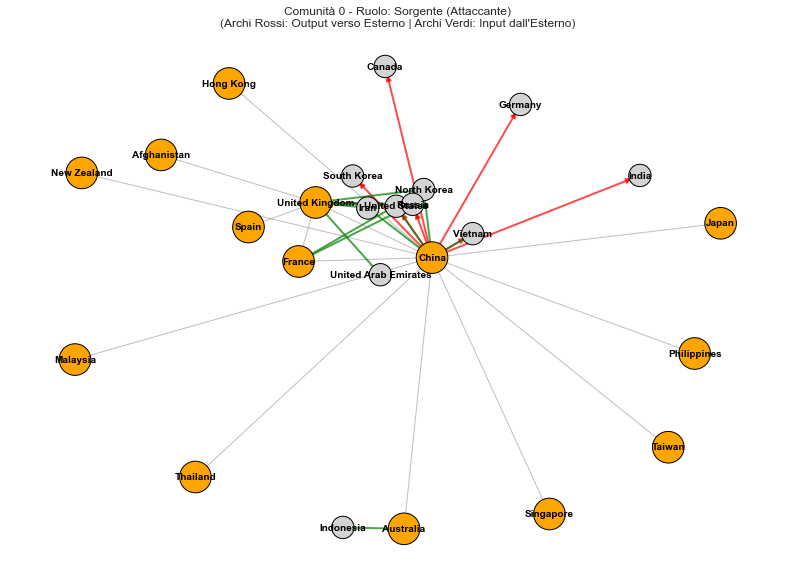

Dettagli Comunità 0 (Sorgente (Attaccante)):
-> Stati Interni (14): Afghanistan, Australia, China, France, Hong Kong, Japan, Malaysia, New Zealand, Philippines, Singapore, Spain, Taiwan, Thailand, United Kingdom
-> Stati Esterni Interagenti (11): Canada, Germany, India, Indonesia, Iran, North Korea, Russia, South Korea, United Arab Emirates, United States, Vietnam
--------------------------------------------------------------------------------


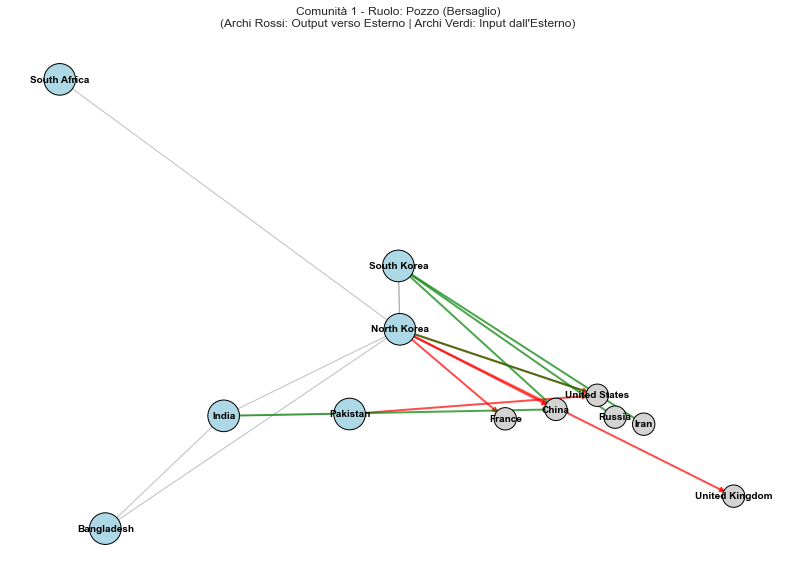

Dettagli Comunità 1 (Pozzo (Bersaglio)):
-> Stati Interni (6): Bangladesh, India, North Korea, Pakistan, South Africa, South Korea
-> Stati Esterni Interagenti (6): China, France, Iran, Russia, United Kingdom, United States
--------------------------------------------------------------------------------


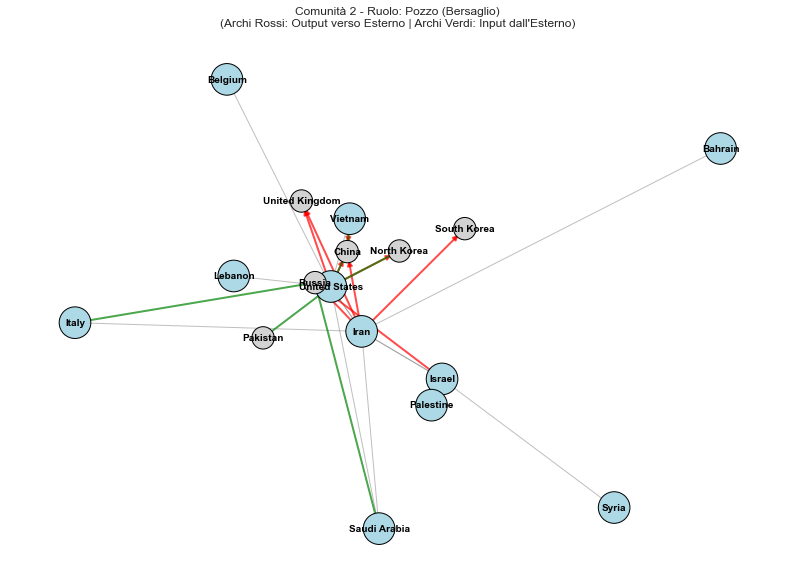

Dettagli Comunità 2 (Pozzo (Bersaglio)):
-> Stati Interni (11): Bahrain, Belgium, Iran, Israel, Italy, Lebanon, Palestine, Saudi Arabia, Syria, United States, Vietnam
-> Stati Esterni Interagenti (6): China, North Korea, Pakistan, Russia, South Korea, United Kingdom
--------------------------------------------------------------------------------


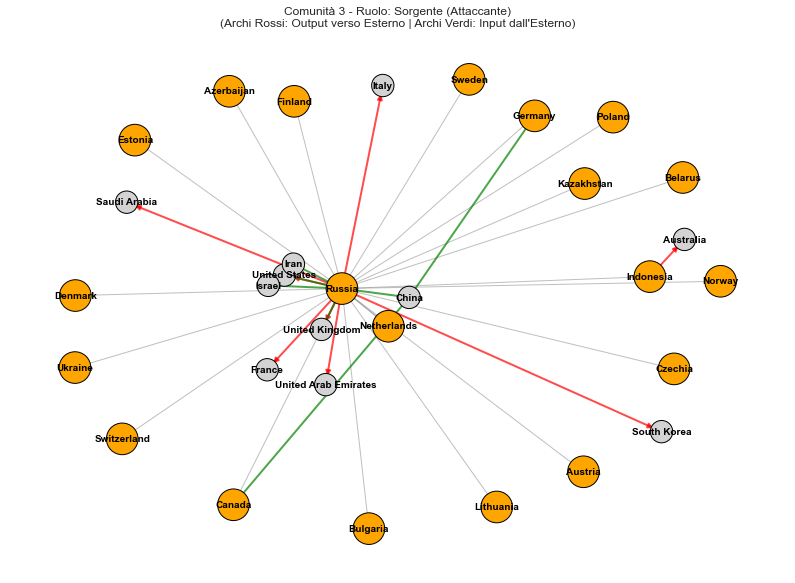

Dettagli Comunità 3 (Sorgente (Attaccante)):
-> Stati Interni (20): Austria, Azerbaijan, Belarus, Bulgaria, Canada, Czechia, Denmark, Estonia, Finland, Germany, Indonesia, Kazakhstan, Lithuania, Netherlands, Norway, Poland, Russia, Sweden, Switzerland, Ukraine
-> Stati Esterni Interagenti (11): Australia, China, France, Iran, Israel, Italy, Saudi Arabia, South Korea, United Arab Emirates, United Kingdom, United States
--------------------------------------------------------------------------------


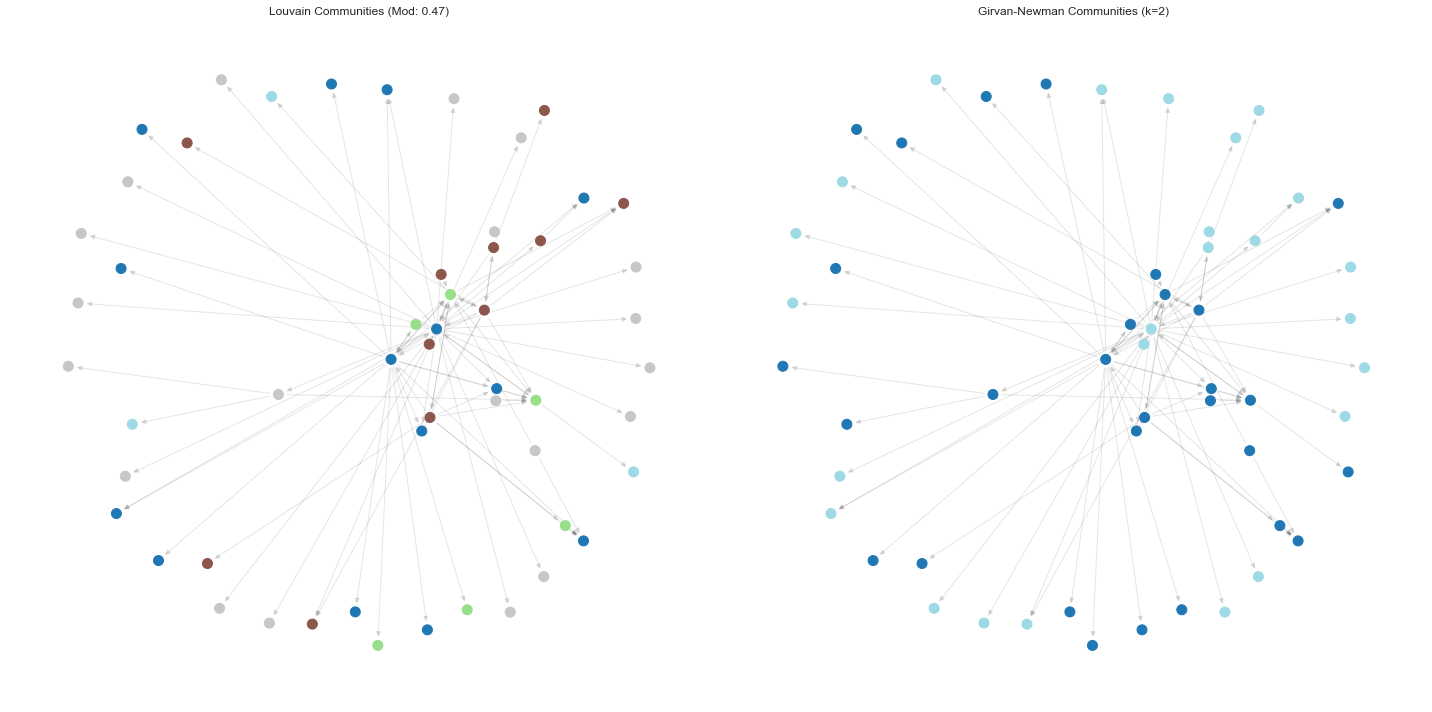

In [104]:
# Analisi Community: Louvain vs Girvan-Newman e Classificazione Sorgente/Pozzo
print("--- Analisi Community Detection e Ruoli (Sorgente/Pozzo) ---")

# 1. Algoritmo Louvain (Ottimizzazione Modularità)
# Utilizziamo l'implementazione nativa di NetworkX invece della libreria esterna 'community'
print("Esecuzione Louvain (NetworkX)...")
# Restituisce una lista di set di nodi
louvain_comms = nx.community.louvain_communities(G_undirected, seed=42)

# Convertiamo in dizionario partition {nodo: id_comunità} per compatibilità
partition_louvain = {}
for idx, comm in enumerate(louvain_comms):
    for node in comm:
        partition_louvain[node] = idx

num_comm_louvain = len(louvain_comms)
# Calcolo modularità usando la funzione di NetworkX (accetta lista di comunità)
mod_louvain = nx.community.modularity(G_undirected, louvain_comms)

print(f"Louvain: Individuate {num_comm_louvain} comunità. Modularità: {mod_louvain:.4f}")

# 2. Algoritmo Girvan-Newman (Rimozione Archi Betweenness)
# Nota: Computazionalmente oneroso. Limitiamo l'iterazione per ottenere un numero di comunità simile a Louvain.
print("Esecuzione Girvan-Newman (potrebbe richiedere tempo)...")
comp_gn = nx.community.girvan_newman(G)
# Iteriamo fino ad ottenere lo stesso numero di comunità di Louvain (o simile)
limited_gn = itertools.islice(comp_gn, num_comm_louvain - 1)
communities_gn = list(next(limited_gn))
partition_gn = {}
for idx, comm in enumerate(communities_gn):
    for node in comm:
        partition_gn[node] = idx

print(f"Girvan-Newman: Partizione in {len(communities_gn)} comunità completata.")

# Funzione per analizzare il ruolo della comunità (Sorgente vs Pozzo)
def analyze_community_role(graph, partition):
    roles = []
    comm_ids = set(partition.values())
    
    for cid in comm_ids:
        nodes_in_comm = [n for n, c in partition.items() if c == cid]
        internal_w = 0
        in_flow = 0
        out_flow = 0
        
        for u in nodes_in_comm:
            # Archi uscenti
            for v in graph.successors(u):
                w = graph[u][v].get('weight', 1)
                if partition.get(v) == cid:
                    internal_w += w
                else:
                    out_flow += w
            # Archi entranti (da nodi esterni)
            for v in graph.predecessors(u):
                if partition.get(v) != cid:
                    w = graph[v][u].get('weight', 1)
                    in_flow += w
                    
        role = "Neutro"
        if out_flow > in_flow * 1.2: role = "Sorgente (Attaccante)"
        elif in_flow > out_flow * 1.2: role = "Pozzo (Bersaglio)"
        
        roles.append({
            'Community_ID': cid,
            'Size': len(nodes_in_comm),
            'In_Flow': in_flow,
            'Out_Flow': out_flow,
            'Role': role
        })
    return pd.DataFrame(roles)

# Analisi Ruoli per Louvain
df_roles_louvain = analyze_community_role(G, partition_louvain)
print("\nAnalisi Ruoli Comunità (Louvain):")
print(df_roles_louvain.sort_values('Size', ascending=False).to_string(index=False))

# --- Visualizzazione Dettagliata Comunità Sorgente/Pozzo ---
print("\n--- Dettaglio Visuale Comunità Sorgente e Pozzo ---")

# Filtriamo solo le comunità che non sono "Neutro"
interesting_communities = df_roles_louvain[df_roles_louvain['Role'] != 'Neutro']

if interesting_communities.empty:
    print("Nessuna comunità chiaramente identificata come Sorgente o Pozzo con i criteri attuali.")
else:
    for _, row in interesting_communities.iterrows():
        cid = row['Community_ID']
        role = row['Role']
        
        # Identifica nodi interni ed esterni collegati
        internal_nodes = [n for n, c in partition_louvain.items() if c == cid]
        external_neighbors = set()
        
        for node in internal_nodes:
            # Aggiungi predecessori e successori che non sono nella comunità
            for neighbor in set(list(G.predecessors(node)) + list(G.successors(node))):
                if partition_louvain.get(neighbor) != cid:
                    external_neighbors.add(neighbor)
        
        external_neighbors = list(external_neighbors)
        
        # Creazione sottografo per visualizzazione
        viz_nodes = internal_nodes + external_neighbors
        G_comm = G.subgraph(viz_nodes)
        
        plt.figure(figsize=(14, 10))
        # Layout: proviamo a raggruppare la comunità al centro
        pos_comm = nx.spring_layout(G_comm, seed=42, k=0.4)
        
        # Colori nodi
        node_colors = []
        for n in G_comm.nodes():
            if n in internal_nodes:
                node_colors.append('orange' if 'Sorgente' in role else 'lightblue')
            else:
                node_colors.append('lightgray')
                
        # Dimensioni nodi
        node_sizes = [1000 if n in internal_nodes else 500 for n in G_comm.nodes()]
        
        nx.draw_networkx_nodes(G_comm, pos_comm, node_color=node_colors, node_size=node_sizes, edgecolors='black')
        nx.draw_networkx_labels(G_comm, pos_comm, font_size=10, font_weight='bold')
        
        # Archi
        # Interni
        edges_internal = [(u, v) for u, v in G_comm.edges() if u in internal_nodes and v in internal_nodes]
        nx.draw_networkx_edges(G_comm, pos_comm, edgelist=edges_internal, edge_color='gray', alpha=0.5)
        
        # Uscenti dalla comunità (Rosso)
        edges_outgoing = [(u, v) for u, v in G_comm.edges() if u in internal_nodes and v in external_neighbors]
        nx.draw_networkx_edges(G_comm, pos_comm, edgelist=edges_outgoing, edge_color='red', width=2.0, alpha=0.7)
        
        # Entranti nella comunità (Verde)
        edges_incoming = [(u, v) for u, v in G_comm.edges() if u in external_neighbors and v in internal_nodes]
        nx.draw_networkx_edges(G_comm, pos_comm, edgelist=edges_incoming, edge_color='green', width=2.0, alpha=0.7)
        
        plt.title(f"Comunità {cid} - Ruolo: {role}\n(Archi Rossi: Output verso Esterno | Archi Verdi: Input dall'Esterno)")
        plt.axis('off')
        plt.savefig(f"{output_folder}/03.2_community_{cid}_detail.png")
        plt.show()
        
        # Stampa elenco stati
        print(f"Dettagli Comunità {cid} ({role}):")
        print(f"-> Stati Interni ({len(internal_nodes)}): {', '.join(sorted(internal_nodes))}")
        print(f"-> Stati Esterni Interagenti ({len(external_neighbors)}): {', '.join(sorted(external_neighbors))}")
        print("-" * 80)

# Visualizzazione Confronto Globale
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot Louvain
pos = nx.spring_layout(G, seed=42, k=0.15)
nx.draw_networkx_nodes(G, pos, node_size=100, cmap=plt.cm.tab20, 
                       node_color=list(partition_louvain.values()), ax=axes[0])
nx.draw_networkx_edges(G, pos, alpha=0.1, ax=axes[0])
axes[0].set_title(f"Louvain Communities (Mod: {mod_louvain:.2f})")
axes[0].axis('off')

# Plot Girvan-Newman
colors_gn = [partition_gn.get(n, 0) for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=100, cmap=plt.cm.tab20, 
                       node_color=colors_gn, ax=axes[1])
nx.draw_networkx_edges(G, pos, alpha=0.1, ax=axes[1])
axes[1].set_title(f"Girvan-Newman Communities (k={len(communities_gn)})")
axes[1].axis('off')

plt.tight_layout()
plt.savefig(f"{output_folder}/03.2_community_comparison.png")
plt.show()